In [1]:
# import dependencies
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

### Using Arrays with Dask

In [2]:
# we are creating an arr with 100,000 data points, and reshaping it to be a
# 200 x 500 two dimensional array
data = np.arange(100_000).reshape(200, 500)

# Now, we create a Dask Array, with 10 chunks each with a shape of 100 x 100
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int32, chunksize=(100, 100), chunktype=numpy.ndarray>

In [3]:
# we can slice arrays like python lists:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int32, chunksize=(50,), chunktype=numpy.ndarray>

In [4]:
# Still, it didn't print the data like a normal python array; this is because
# Dask is lazily evaluated, and will only compute a result when explicitly asked
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [5]:
# existing numpy and pandas methods exist on a Dask Array
print(a.mean())
print(a.mean().compute())

# Other iterative operations can be applied to a Dask Array as well, but again
# will only be computed when explicitly asked
print(np.sin(a))
print(np.sin(a).compute())

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
49999.5
dask.array<sin, shape=(200, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
[[ 0.          0.84147098  0.90929743 ...  0.58781939  0.99834363
   0.49099533]
 [-0.46777181 -0.9964717  -0.60902011 ... -0.89796748 -0.85547315
  -0.02646075]
 [ 0.82687954  0.9199906   0.16726654 ...  0.99951642  0.51387502
  -0.4442207 ]
 ...
 [-0.99720859 -0.47596473  0.48287891 ... -0.76284376  0.13191447
   0.90539115]
 [ 0.84645538  0.00929244 -0.83641393 ...  0.37178568 -0.5802765
  -0.99883514]
 [-0.49906936  0.45953849  0.99564877 ...  0.10563876  0.89383946
   0.86024828]]


In [6]:
# Just like in numpy, we can perform method chaining as well

# get the max value of each row in a, then reverse the resulting array and add 10 to each value
b = a.max(axis=1)[::-1] + 10
print(b)

b[:10].compute()

dask.array<add, shape=(200,), dtype=int32, chunksize=(100,), chunktype=numpy.ndarray>


array([100009,  99509,  99009,  98509,  98009,  97509,  97009,  96509,
        96009,  95509])

In [7]:
# We can view a breakdown of the steps leading to the creation of the b array
b.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2005688a400>
 0. array-cc776c6b9a569dbadabcea53d1c7a075
 1. amax-f781ca5547b560104e485a82fd7e48f5
 2. amax-partial-c031fed96425d74fd36fc171498f832e
 3. amax-aggregate-17ef9b17ecc7caaad25af8c096910859
 4. getitem-57cab4abde5abad705979faab7bae4d3
 5. add-08b5c25edd0395f659dd9465cb4d3ecf

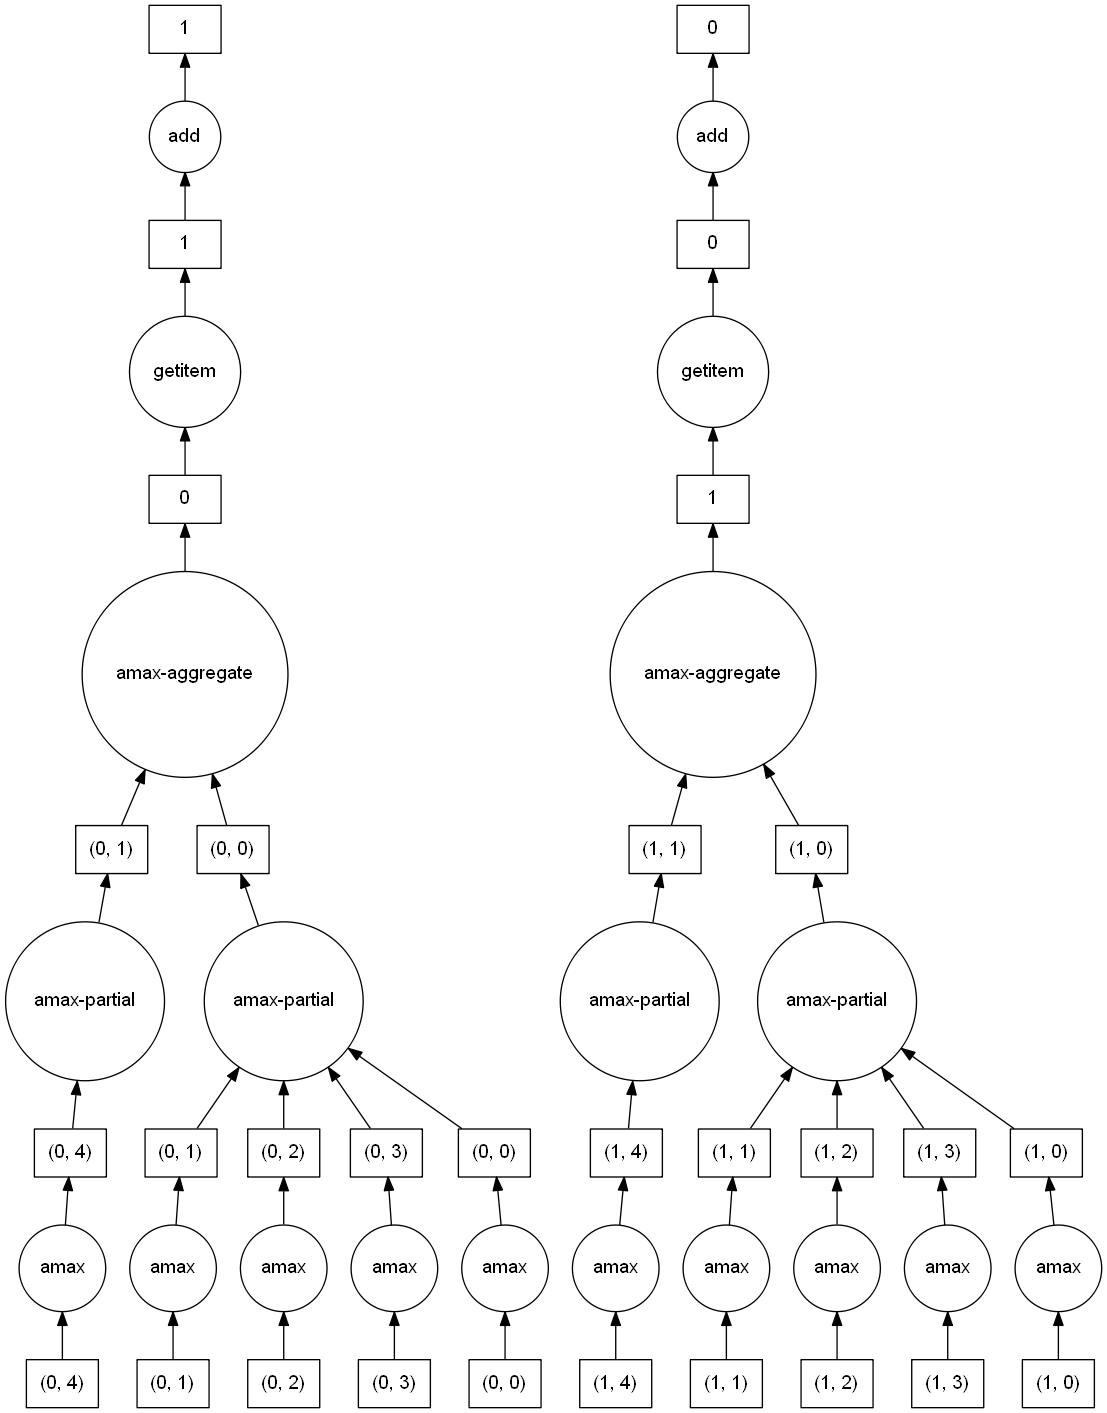

In [8]:
# These steps can be further visualized like so:
b.visualize()

### Using DataFrames with Dask

In [9]:
index = pd.date_range("2021-09-01", periods=2400, freq="1H") # create indices as datetimes

df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index) # create a df with two columns and 2400 rows

ddf = dd.from_pandas(df, npartitions=10) # create a Dask DataFrame, composed of 10 partitions (240 rows each)
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int32,object
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [11]:
# lazy loading just like arrays
print(ddf.a.mean())
print(ddf.a.mean().compute())

print("\n===========\n")

print(ddf.b.unique())
print(ddf.b.unique().compute())

dd.Scalar<series-..., dtype=float64>
1199.5


Dask Series Structure:
npartitions=1
    object
       ...
Name: b, dtype: object
Dask Name: unique-agg, 33 tasks
0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object


In [13]:
# of course, methods can be chained together just like in pandas
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
print(result)
print(result.compute())

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int32
2021-10-09 05:00:59.999999999      ...
Name: a, dtype: int32
Dask Name: sub, 16 tasks
2021-10-01 00:00:00       620
2021-10-01 01:00:00      1341
2021-10-01 02:00:00      2063
2021-10-01 03:00:00      2786
2021-10-01 04:00:00      3510
                        ...  
2021-10-09 01:00:00    158301
2021-10-09 02:00:00    159215
2021-10-09 03:00:00    160130
2021-10-09 04:00:00    161046
2021-10-09 05:00:00    161963
Freq: H, Name: a, Length: 198, dtype: int32


In [14]:
result.dask

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x20057bd8d30>
 0. from_pandas-42e14229b15bb19885f22f17760fe89a
 1. loc-43096a15bc09853339dad9b1ece1872e
 2. getitem-37f1b064dec8378ec750bd33779f887c
 3. series-cumsum-map-eaecc4e3a558093f20be6e8d34650d49
 4. series-cumsum-take-last-721995ecdd595585387f8a48d40e686c
 5. series-cumsum-f7b1244cfc321d7937d742f4cc7996b9
 6. sub-839c242633174e532868d06380d4e322

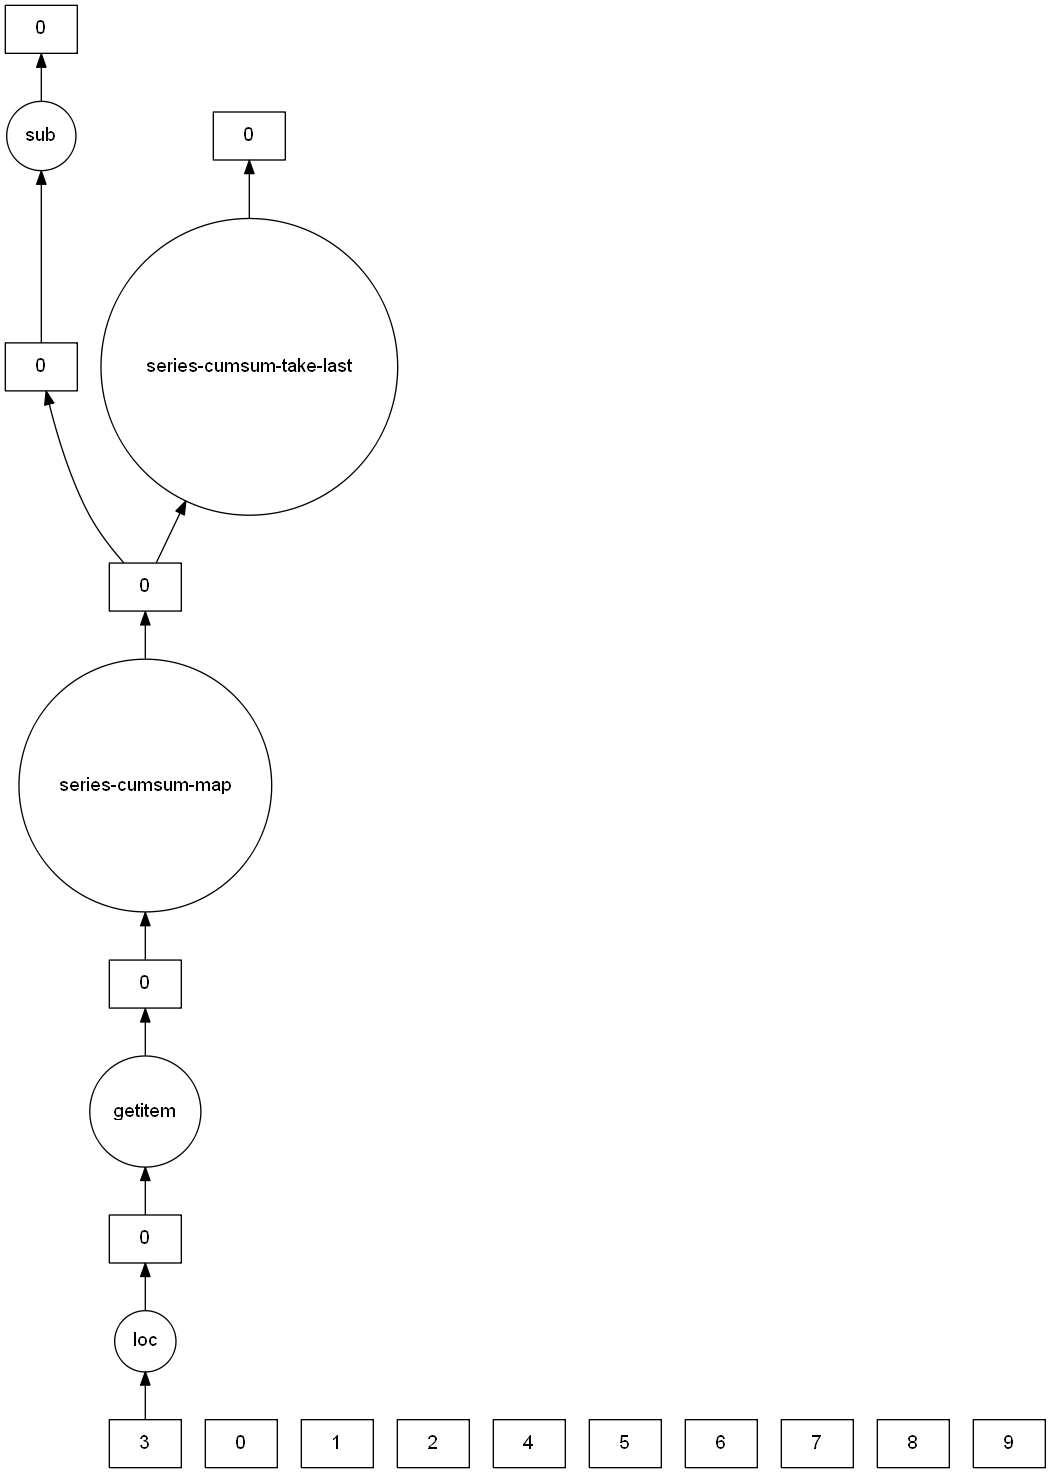

In [15]:
result.visualize()